In [4]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create project structure
PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'
folders = [
    f'{PROJECT_ROOT}',
    f'{PROJECT_ROOT}/data',
    f'{PROJECT_ROOT}/data/raw',
    f'{PROJECT_ROOT}/src',
    f'{PROJECT_ROOT}/models',
    f'{PROJECT_ROOT}/results',
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)
    print(f'✓ {folder}')


Mounted at /content/drive
✓ /content/drive/MyDrive/solar-defect-detection
✓ /content/drive/MyDrive/solar-defect-detection/data
✓ /content/drive/MyDrive/solar-defect-detection/data/raw
✓ /content/drive/MyDrive/solar-defect-detection/src
✓ /content/drive/MyDrive/solar-defect-detection/models
✓ /content/drive/MyDrive/solar-defect-detection/results


In [5]:
print("\nStep 3: Creating requirements.txt...")
requirements = '''torch==2.0.0
torchvision==0.15.0
numpy==1.24.0
pandas==1.5.3
opencv-python==4.7.0
pillow==9.5.0
matplotlib==3.7.0
scikit-learn==1.2.2
streamlit==1.28.0
tqdm==4.65.0
jupyter==1.0.0
'''

with open(f'{PROJECT_ROOT}/requirements.txt', 'w') as f:
    f.write(requirements)

print("✓ requirements.txt created!")

print("\nStep 4: Installing libraries...")
!pip install -q torch torchvision numpy pandas opencv-python pillow matplotlib scikit-learn streamlit tqdm

print("✓ All libraries installed!")

print("\n" + "="*60)
print("✓ COLAB SETUP COMPLETE!")
print("="*60)
print(f"\nYour project root: {PROJECT_ROOT}")
print(f"\nYou can now:")
print(f"1. Change directory: %cd {PROJECT_ROOT}")
print(f"2. Download datasets")
print(f"3. Create Python scripts in src/")
print(f"4. Train models")
print(f"5. Save results to results/")


Step 3: Creating requirements.txt...
✓ requirements.txt created!

Step 4: Installing libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 111.6 MB/s eta 0:00:00
✓ All libraries installed!

✓ COLAB SETUP COMPLETE!

Your project root: /content/drive/MyDrive/solar-defect-detection

You can now:
1. Change directory: %cd /content/drive/MyDrive/solar-defect-detection
2. Download datasets
3. Create Python scripts in src/
4. Train models
5. Save results to results/


In [6]:
# Download datasets to Google Drive
!pip install -q kaggle

# Step 1: You need kaggle.json from https://www.kaggle.com/settings/account
# Download it and upload to Colab (Files panel on left → Upload)

# Step 2: Setup kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 3: Download dataset
PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'
dataset_name = 'neurobotdata/photovoltaic-panel-defect-dataset'
download_path = f'{PROJECT_ROOT}/data/raw'

!kaggle datasets download -d {dataset_name} -p {download_path} --unzip

print('✓ Dataset downloaded successfully!')


cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
✓ Dataset downloaded successfully!


In [7]:
import os
from pathlib import Path

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'
data_raw = f'{PROJECT_ROOT}/data/raw'

# List what's in the raw data folder
print("Contents of data/raw:")
!ls -lah {data_raw}

# Check if dataset was extracted
!ls {data_raw} | head -20


Contents of data/raw:
total 16K
drwx------ 2 root root 4.0K Dec 15 14:48 'Photovoltaic panel defects'
drwx------ 2 root root 4.0K Dec 15 15:28  PVEL_S
drwx------ 2 root root 4.0K Dec 15 15:28  SolarCells
drwx------ 2 root root 4.0K Dec 15 15:28  SolarCells_S
Photovoltaic panel defects
PVEL_S
SolarCells
SolarCells_S


In [8]:
import os
from pathlib import Path

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'
data_raw = f'{PROJECT_ROOT}/data/raw'

# Count images in each class
print("Dataset Statistics:")
print("=" * 50)

classes = sorted([d for d in os.listdir(data_raw) if os.path.isdir(os.path.join(data_raw, d))])

total_images = 0
for class_name in classes:
    class_path = os.path.join(data_raw, class_name)
    image_count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    total_images += image_count
    print(f"{class_name}: {image_count} images")

print("=" * 50)
print(f"Total images: {total_images}")
print(f"Total classes: {len(classes)}")


Dataset Statistics:
PVEL_S: 0 images
Photovoltaic panel defects: 145 images
SolarCells: 0 images
SolarCells_S: 0 images
Total images: 145
Total classes: 4


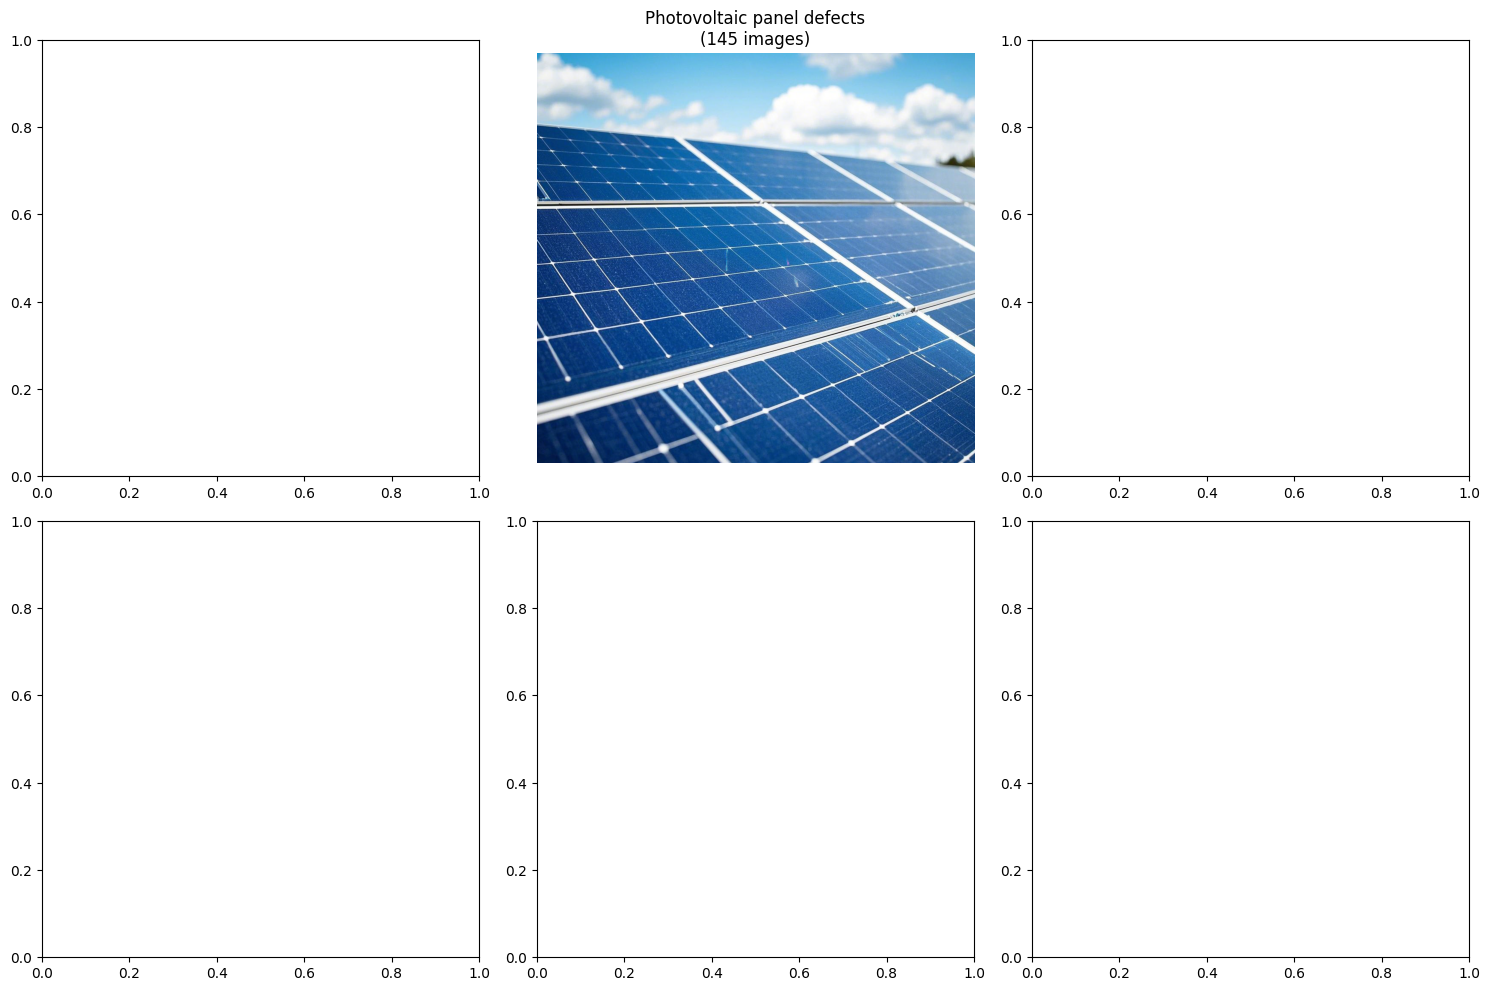

✓ Sample images saved to: /content/drive/MyDrive/solar-defect-detection/results/plots/dataset_samples.png


In [9]:
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'
data_raw = f'{PROJECT_ROOT}/data/raw'

# Get all classes
classes = sorted([d for d in os.listdir(data_raw) if os.path.isdir(os.path.join(data_raw, d))])

# Create figure with subplots (one for each class)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, class_name in enumerate(classes):
    if idx >= 6:
        break

    class_path = os.path.join(data_raw, class_name)

    # Get first image
    images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    if images:
        image_path = os.path.join(class_path, images[0])

        # Read image
        img = cv2.imread(image_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Display
            axes[idx].imshow(img)
            axes[idx].set_title(f"{class_name}\n({len(images)} images)")
            axes[idx].axis('off')

# Save figure
save_path = f'{PROJECT_ROOT}/results/plots/dataset_samples.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.tight_layout()
plt.savefig(save_path, dpi=150)
plt.show()

print(f'✓ Sample images saved to: {save_path}')


In [10]:
import os
from pathlib import Path

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'

# Option 1: Download the second dataset (Solar Cells Defect Segmentation)
# This one has proper class structure

print("Downloading additional dataset with proper class structure...")
!pip install -q kaggle

# Make sure kaggle.json is still available
dataset_name = 'xiaoyunchen666/dataset-of-solar-cells-defect-segmentation'
download_path = f'{PROJECT_ROOT}/data/raw'

!kaggle datasets download -d {dataset_name} -p {download_path} --unzip

print('\n✓ Additional dataset downloaded!')

# Now check what we have
print("\n\nChecking updated dataset structure:")
data_raw = f'{PROJECT_ROOT}/data/raw'
!ls -lah {data_raw}


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'

✓ Additional dataset downloaded!


Checking updated dataset structure:
total 16K
drwx------ 3 root root 4.0K Dec 15 14:48 'Photovoltaic panel defects'
drwx------ 3 root root 4.0K Dec 15 15:28  PVEL_S
drwx------ 3 root root 4.0K Dec 15 15:28  SolarCells
drwx------ 3 root root 4.0K Dec 15 

In [11]:
import os
from pathlib import Path

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'
data_raw = f'{PROJECT_ROOT}/data/raw'

print("="*70)
print("DEEP EXPLORATION OF ALL DATASETS")
print("="*70)

# Check each main folder
main_folders = os.listdir(data_raw)

for main_folder in sorted(main_folders):
    main_path = os.path.join(data_raw, main_folder)

    if os.path.isdir(main_path):
        print(f"\n📁 Dataset: {main_folder}")
        print("-" * 70)

        # Look for subfolders recursively
        all_classes = {}

        for root, dirs, files in os.walk(main_path):
            # Count images in current directory
            image_files = [f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))]
            if image_files:
                # Get the folder name relative to main_path
                rel_path = os.path.relpath(root, main_path)
                all_classes[rel_path] = len(image_files)

        # Display results
        if all_classes:
            print(f"Classes found: {len(all_classes)}")
            total = 0
            for class_name in sorted(all_classes.keys()):
                count = all_classes[class_name]
                print(f"  - {class_name}: {count} images")
                total += count
            print(f"Total images: {total}")
        else:
            print("No images found in this dataset")

print("\n" + "="*70)
print("\nRECOMMENDATION:")
print("="*70)
print("Pick the dataset with:")
print("✓ 5+ classes (defect types)")
print("✓ 500+ total images")
print("✓ Balanced classes (similar counts)")


DEEP EXPLORATION OF ALL DATASETS

📁 Dataset: PVEL_S
----------------------------------------------------------------------
Classes found: 4
  - PVEL_S/test/defect: 240 images
  - PVEL_S/test/label: 240 images
  - PVEL_S/train/defect: 960 images
  - PVEL_S/train/label: 960 images
Total images: 2400

📁 Dataset: Photovoltaic panel defects
----------------------------------------------------------------------
Classes found: 1
  - .: 145 images
Total images: 145

📁 Dataset: SolarCells
----------------------------------------------------------------------
Classes found: 4
  - SolarCells/test/defect: 38 images
  - SolarCells/test/label: 38 images
  - SolarCells/train/defect: 152 images
  - SolarCells/train/label: 152 images
Total images: 380

📁 Dataset: SolarCells_S
----------------------------------------------------------------------
Classes found: 4
  - SolarCells_S/test/defect: 36 images
  - SolarCells_S/test/label: 36 images
  - SolarCells_S/train/defect: 144 images
  - SolarCells_S/trai

In [12]:
import os
import shutil
from pathlib import Path

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'
data_raw = f'{PROJECT_ROOT}/data/raw'
data_processed = f'{PROJECT_ROOT}/data/processed'

print("Step 1: Creating processed data folders...")

# Create processed data structure
os.makedirs(f'{data_processed}/train/images', exist_ok=True)
os.makedirs(f'{data_processed}/train/masks', exist_ok=True)
os.makedirs(f'{data_processed}/test/images', exist_ok=True)
os.makedirs(f'{data_processed}/test/masks', exist_ok=True)

print("✓ Created processed data folders\n")

# The actual path has double PVEL_S folder!
pvel_actual_path = f'{data_raw}/PVEL_S/PVEL_S'

print("Step 2: Copying training data...")
train_defect_src = f'{pvel_actual_path}/train/defect'
train_defect_dst = f'{data_processed}/train/images'

if os.path.exists(train_defect_src):
    count = 0
    for img in os.listdir(train_defect_src):
        src = os.path.join(train_defect_src, img)
        dst = os.path.join(train_defect_dst, img)
        if os.path.isfile(src):
            shutil.copy2(src, dst)
            count += 1
    print(f"✓ Copied {count} training images")
else:
    print(f"❌ Not found: {train_defect_src}")

print("\nStep 3: Copying training masks...")
train_label_src = f'{pvel_actual_path}/train/label'
train_label_dst = f'{data_processed}/train/masks'

if os.path.exists(train_label_src):
    count = 0
    for img in os.listdir(train_label_src):
        src = os.path.join(train_label_src, img)
        dst = os.path.join(train_label_dst, img)
        if os.path.isfile(src):
            shutil.copy2(src, dst)
            count += 1
    print(f"✓ Copied {count} training masks")
else:
    print(f"❌ Not found: {train_label_src}")

print("\nStep 4: Copying test data...")
test_defect_src = f'{pvel_actual_path}/test/defect'
test_defect_dst = f'{data_processed}/test/images'

if os.path.exists(test_defect_src):
    count = 0
    for img in os.listdir(test_defect_src):
        src = os.path.join(test_defect_src, img)
        dst = os.path.join(test_defect_dst, img)
        if os.path.isfile(src):
            shutil.copy2(src, dst)
            count += 1
    print(f"✓ Copied {count} test images")
else:
    print(f"❌ Not found: {test_defect_src}")

print("\nStep 5: Copying test masks...")
test_label_src = f'{pvel_actual_path}/test/label'
test_label_dst = f'{data_processed}/test/masks'

if os.path.exists(test_label_src):
    count = 0
    for img in os.listdir(test_label_src):
        src = os.path.join(test_label_src, img)
        dst = os.path.join(test_label_dst, img)
        if os.path.isfile(src):
            shutil.copy2(src, dst)
            count += 1
    print(f"✓ Copied {count} test masks")
else:
    print(f"❌ Not found: {test_label_src}")

print("\n" + "="*70)
print("✓ PVEL_S DATASET ORGANIZED!")
print("="*70)

# Final verification
print("\nFinal structure:")
for root, dirs, files in os.walk(data_processed):
    level = root.replace(data_processed, '').count(os.sep)
    indent = '  ' * level
    folder_name = os.path.basename(root)
    print(f'{indent}{folder_name}/')

    if files:
        subindent = '  ' * (level + 1)
        print(f'{subindent}Files: {len(files)}')


Step 1: Creating processed data folders...
✓ Created processed data folders

Step 2: Copying training data...
✓ Copied 960 training images

Step 3: Copying training masks...
✓ Copied 960 training masks

Step 4: Copying test data...
✓ Copied 240 test images

Step 5: Copying test masks...
✓ Copied 240 test masks

✓ PVEL_S DATASET ORGANIZED!

Final structure:
processed/
  train/
    images/
      Files: 960
    masks/
      Files: 960
  test/
    images/
      Files: 240
    masks/
      Files: 240


Showing sample images from organized dataset



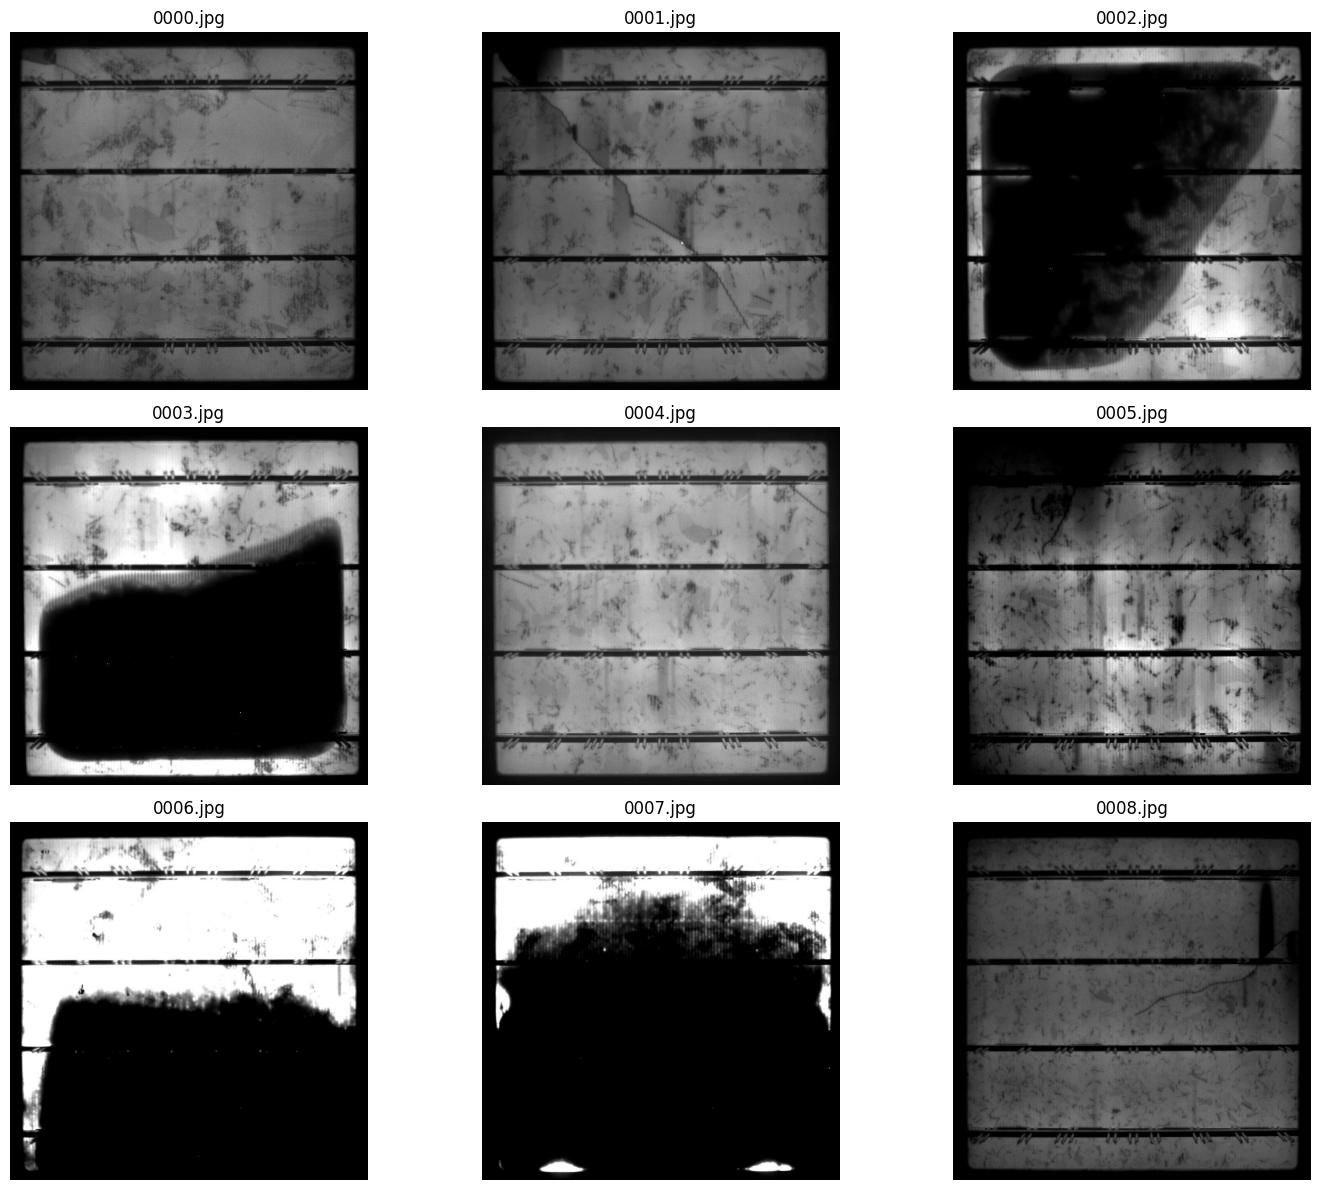

✓ Sample images saved to: /content/drive/MyDrive/solar-defect-detection/results/plots/pvel_s_samples.png

📊 DATASET READY FOR TRAINING!
Training images: 960
Training masks: 960
Test images: 240
Test masks: 240


In [13]:
import cv2
import matplotlib.pyplot as plt
import os

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'
data_processed = f'{PROJECT_ROOT}/data/processed'

print("Showing sample images from organized dataset\n")

# Get training images and masks
train_img_path = f'{data_processed}/train/images'
train_mask_path = f'{data_processed}/train/masks'

images = sorted(os.listdir(train_img_path))[:9]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, img_name in enumerate(images):
    img_path = os.path.join(train_img_path, img_name)
    img = cv2.imread(img_path)

    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_name}")
        axes[idx].axis('off')

plt.tight_layout()
save_path = f'{PROJECT_ROOT}/results/plots/pvel_s_samples.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Sample images saved to: {save_path}")
print(f"\n📊 DATASET READY FOR TRAINING!")
print(f"Training images: {len(os.listdir(train_img_path))}")
print(f"Training masks: {len(os.listdir(train_mask_path))}")
print(f"Test images: {len(os.listdir(f'{data_processed}/test/images'))}")
print(f"Test masks: {len(os.listdir(f'{data_processed}/test/masks'))}")


In [14]:
import torch
import cv2
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'

class SolarDefectDataset(Dataset):
    """
    Solar Panel Defect Segmentation Dataset
    Loads images and their corresponding segmentation masks
    """
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Get list of image files
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale

        # Load corresponding mask
        mask_name = img_name.replace('.jpg', '_mask.jpg')
        mask_path = os.path.join(self.mask_dir, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscale

        # Resize to 256x256 for consistency
        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        # Normalize image to [0, 1]
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Convert to tensors
        image = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension
        mask = torch.from_numpy(mask).unsqueeze(0)    # Add channel dimension

        return {
            'image': image,
            'mask': mask,
            'name': img_name
        }

# Create datasets
train_image_dir = f'{PROJECT_ROOT}/data/processed/train/images'
train_mask_dir = f'{PROJECT_ROOT}/data/processed/train/masks'
test_image_dir = f'{PROJECT_ROOT}/data/processed/test/images'
test_mask_dir = f'{PROJECT_ROOT}/data/processed/test/masks'

print("Creating datasets...")
train_dataset = SolarDefectDataset(train_image_dir, train_mask_dir)
test_dataset = SolarDefectDataset(test_image_dir, test_mask_dir)

print(f"✓ Training dataset: {len(train_dataset)} samples")
print(f"✓ Test dataset: {len(test_dataset)} samples")

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\n✓ DataLoaders created!")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Test batches: {len(test_loader)}")

# Test loading a batch
print("\nTesting data loading...")
batch = next(iter(train_loader))
print(f"  - Batch image shape: {batch['image'].shape}")
print(f"  - Batch mask shape: {batch['mask'].shape}")
print(f"  - Image dtype: {batch['image'].dtype}")
print(f"  - Mask dtype: {batch['mask'].dtype}")

print("\n✅ DATA PIPELINE READY FOR TRAINING!")


Creating datasets...
✓ Training dataset: 960 samples
✓ Test dataset: 240 samples

✓ DataLoaders created!
  - Train batches: 60
  - Test batches: 15

Testing data loading...
  - Batch image shape: torch.Size([16, 1, 256, 256])
  - Batch mask shape: torch.Size([16, 1, 256, 256])
  - Image dtype: torch.float32
  - Mask dtype: torch.float32

✅ DATA PIPELINE READY FOR TRAINING!


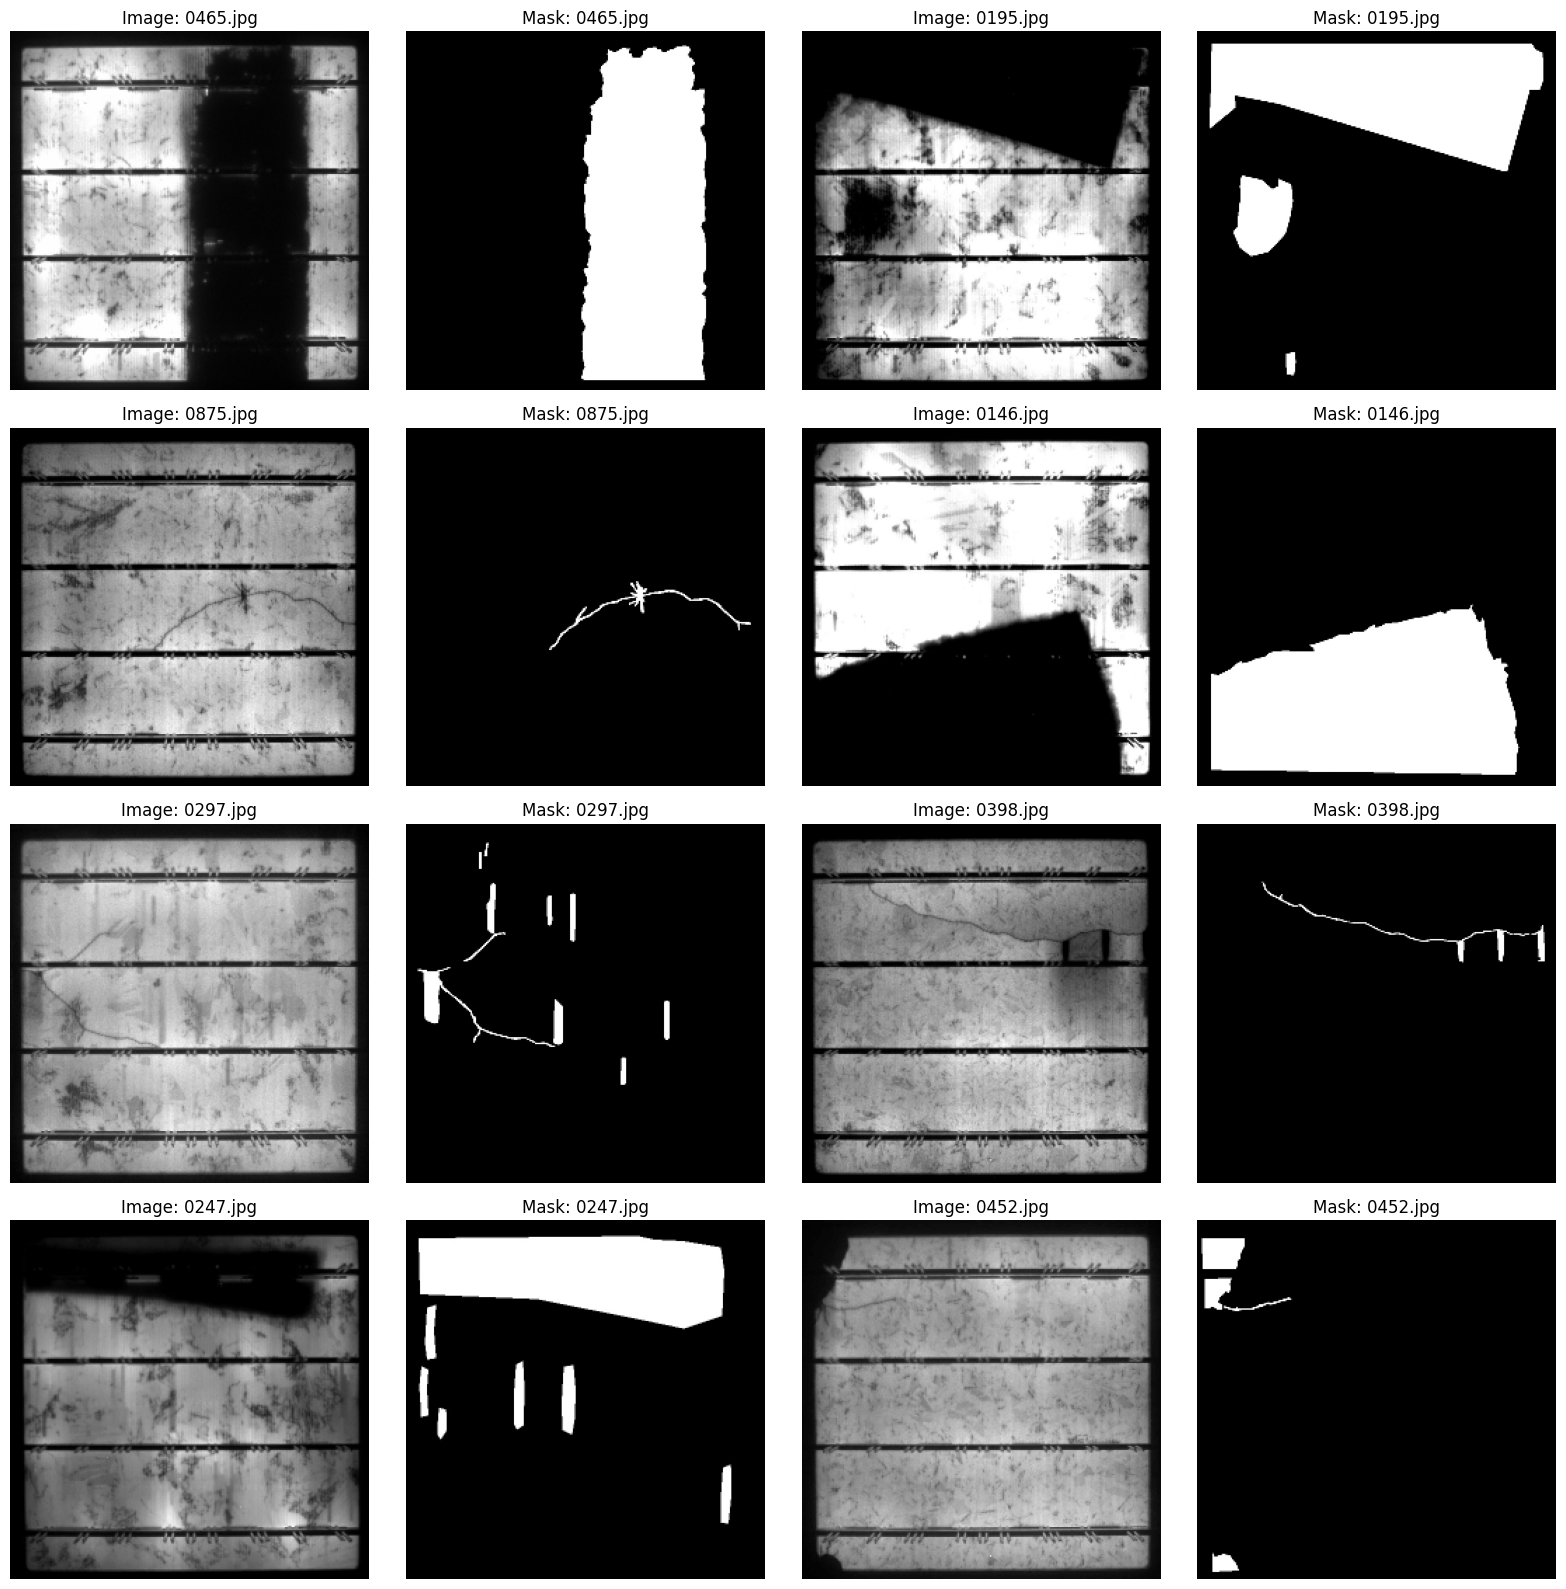

✓ Sample visualization saved!


In [15]:
import matplotlib.pyplot as plt

# Get a batch
batch = next(iter(train_loader))
images = batch['image']
masks = batch['mask']
names = batch['name']

# Show first 8 samples
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.ravel()

for i in range(8):
    # Image
    axes[2*i].imshow(images[i, 0].cpu().numpy(), cmap='gray')
    axes[2*i].set_title(f"Image: {names[i][:15]}")
    axes[2*i].axis('off')

    # Mask
    axes[2*i+1].imshow(masks[i, 0].cpu().numpy(), cmap='gray')
    axes[2*i+1].set_title(f"Mask: {names[i][:15]}")
    axes[2*i+1].axis('off')

plt.tight_layout()
save_path = f'{PROJECT_ROOT}/results/plots/data_loader_samples.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Sample visualization saved!")


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'

class UNet(nn.Module):
    """
    U-Net Architecture for Image Segmentation
    Input: (B, 1, 256, 256)
    Output: (B, 1, 256, 256)
    """

    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder (Downsampling)
        self.enc1 = self.conv_block(in_channels, 64)      # 256 -> 256
        self.pool1 = nn.MaxPool2d(2)                       # 256 -> 128

        self.enc2 = self.conv_block(64, 128)               # 128 -> 128
        self.pool2 = nn.MaxPool2d(2)                       # 128 -> 64

        self.enc3 = self.conv_block(128, 256)              # 64 -> 64
        self.pool3 = nn.MaxPool2d(2)                       # 64 -> 32

        self.enc4 = self.conv_block(256, 512)              # 32 -> 32
        self.pool4 = nn.MaxPool2d(2)                       # 32 -> 16

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)       # 16 -> 16

        # Decoder (Upsampling)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)  # 16 -> 32
        self.dec4 = self.conv_block(1024, 512)             # 32 -> 32

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)   # 32 -> 64
        self.dec3 = self.conv_block(512, 256)              # 64 -> 64

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)   # 64 -> 128
        self.dec2 = self.conv_block(256, 128)              # 128 -> 128

        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)    # 128 -> 256
        self.dec1 = self.conv_block(128, 64)               # 256 -> 256

        # Final output layer
        self.final = nn.Conv2d(64, out_channels, 1)        # 1x1 conv

    def conv_block(self, in_ch, out_ch):
        """Double convolution block: Conv2d -> BatchNorm -> ReLU -> Conv2d -> BatchNorm -> ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder with skip connections
        enc1 = self.enc1(x)
        x = self.pool1(enc1)

        enc2 = self.enc2(x)
        x = self.pool2(enc2)

        enc3 = self.enc3(x)
        x = self.pool3(enc3)

        enc4 = self.enc4(x)
        x = self.pool4(enc4)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder with skip connections
        x = self.upconv4(x)
        x = torch.cat([x, enc4], dim=1)  # Skip connection
        x = self.dec4(x)

        x = self.upconv3(x)
        x = torch.cat([x, enc3], dim=1)  # Skip connection
        x = self.dec3(x)

        x = self.upconv2(x)
        x = torch.cat([x, enc2], dim=1)  # Skip connection
        x = self.dec2(x)

        x = self.upconv1(x)
        x = torch.cat([x, enc1], dim=1)  # Skip connection
        x = self.dec1(x)

        # Final output
        x = self.final(x)
        x = torch.sigmoid(x)  # Sigmoid for binary segmentation

        return x

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, out_channels=1).to(device)

print("="*70)
print("U-NET MODEL CREATED")
print("="*70)
print(f"\nDevice: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Test with dummy input
print("\nTesting model with dummy input...")
dummy_input = torch.randn(2, 1, 256, 256).to(device)
dummy_output = model(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {dummy_output.shape}")
print(f"Output range: [{dummy_output.min():.4f}, {dummy_output.max():.4f}]")

print("\n✅ U-NET MODEL READY FOR TRAINING!")

# Save model architecture summary
print("\nModel Summary:")
print(model)


U-NET MODEL CREATED

Device: cuda
Model parameters: 31,042,369
Trainable parameters: 31,042,369

Testing model with dummy input...
Input shape: torch.Size([2, 1, 256, 256])
Output shape: torch.Size([2, 1, 256, 256])
Output range: [0.2278, 0.9085]

✅ U-NET MODEL READY FOR TRAINING!

Model Summary:
UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import json
import os

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define loss function (Dice Loss + Binary Cross Entropy)
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        smooth = 1e-5
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth)
        return 1 - dice

def dice_score(pred, target):
    """Calculate Dice coefficient"""
    smooth = 1e-5
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    dice = (2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice.item()

def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_dice = 0

    pbar = tqdm(train_loader, desc="Training", leave=False)
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        # Calculate loss
        bce_loss = nn.BCELoss()(outputs, masks)
        dice_loss = DiceLoss()(outputs, masks)
        loss = 0.5 * bce_loss + 0.5 * dice_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate metrics
        total_loss += loss.item()
        total_dice += dice_score(outputs, masks)

        # Fixed: proper f-string formatting
        loss_val = loss.item()
        pbar.set_postfix({'loss': f'{loss_val:.4f}'})

    return total_loss / len(train_loader), total_dice / len(train_loader)

def validate(model, test_loader, criterion, device):
    """Validate on test set"""
    model.eval()
    total_loss = 0
    total_dice = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validating", leave=False):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            bce_loss = nn.BCELoss()(outputs, masks)
            dice_loss = DiceLoss()(outputs, masks)
            loss = 0.5 * bce_loss + 0.5 * dice_loss

            # Calculate metrics
            total_loss += loss.item()
            total_dice += dice_score(outputs, masks)

    return total_loss / len(test_loader), total_dice / len(test_loader)

# Training parameters
num_epochs = 20
learning_rate = 0.001
batch_size = 16

# Initialize model, optimizer, and loss
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = DiceLoss()

# Training history
history = {
    'train_loss': [],
    'train_dice': [],
    'val_loss': [],
    'val_dice': []
}

print("="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Device: {device}")
print(f"Epochs: {num_epochs}")
print(f"Learning rate: {learning_rate}")
print(f"Batch size: {batch_size}")
print("="*70 + "\n")

# Training loop
for epoch in range(num_epochs):
    train_loss, train_dice = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(model, test_loader, criterion, device)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Dice:   {val_dice:.4f}")

    # Save best model
    if epoch == 0 or val_dice > max(history['val_dice'][:-1]):
        model_path = f'{PROJECT_ROOT}/models/best_model.pth'
        torch.save(model.state_dict(), model_path)
        print(f"  ✓ Best model saved!")
    print()

# Save training history
history_path = f'{PROJECT_ROOT}/results/training_history.json'
with open(history_path, 'w') as f:
    json.dump(history, f, indent=4)

print("="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)
print(f"Best model saved to: {PROJECT_ROOT}/models/best_model.pth")
print(f"Training history saved to: {history_path}")


STARTING TRAINING
Device: cuda
Epochs: 20
Learning rate: 0.001
Batch size: 16



Epoch 1/20
  Train Loss: 0.3576 | Train Dice: 0.8232
  Val Loss:   0.3390 | Val Dice:   0.7855
  ✓ Best model saved!



Epoch 2/20
  Train Loss: 0.1787 | Train Dice: 0.9050
  Val Loss:   0.1151 | Val Dice:   0.9374
  ✓ Best model saved!



Epoch 3/20
  Train Loss: 0.1090 | Train Dice: 0.9275
  Val Loss:   0.1041 | Val Dice:   0.9450
  ✓ Best model saved!



Epoch 4/20
  Train Loss: 0.0897 | Train Dice: 0.9336
  Val Loss:   0.0672 | Val Dice:   0.9478
  ✓ Best model saved!



Epoch 5/20
  Train Loss: 0.0787 | Train Dice: 0.9370
  Val Loss:   0.1110 | Val Dice:   0.9198



Epoch 6/20
  Train Loss: 0.0735 | Train Dice: 0.9398
  Val Loss:   0.0841 | Val Dice:   0.9299



Epoch 7/20
  Train Loss: 0.0845 | Train Dice: 0.9263
  Val Loss:   0.0599 | Val Dice:   0.9500
  ✓ Best model saved!



Epoch 8/20
  Train Loss: 0.0696 | Train Dice: 0.9404
  Val Loss:   0.0585 | Val Dice:   0.9507
  ✓ Best model saved!



Epoch 9/20
  Train Loss: 0.0691 | Train Dice: 0.9398
  Val Loss:   0.0814 | Val Dice:   0.9317



Epoch 10/20
  Train Loss: 0.0752 | Train Dice: 0.9322
  Val Loss:   0.0603 | Val Dice:   0.9507
  ✓ Best model saved!



Epoch 11/20
  Train Loss: 0.0642 | Train Dice: 0.9430
  Val Loss:   0.0547 | Val Dice:   0.9535
  ✓ Best model saved!



Epoch 12/20
  Train Loss: 0.0617 | Train Dice: 0.9456
  Val Loss:   0.0737 | Val Dice:   0.9383



Epoch 13/20
  Train Loss: 0.0603 | Train Dice: 0.9467
  Val Loss:   0.0545 | Val Dice:   0.9516



Epoch 14/20
  Train Loss: 0.0568 | Train Dice: 0.9498
  Val Loss:   0.1014 | Val Dice:   0.9249



Epoch 15/20
  Train Loss: 0.0562 | Train Dice: 0.9492
  Val Loss:   0.0521 | Val Dice:   0.9532



Epoch 16/20
  Train Loss: 0.0535 | Train Dice: 0.9523
  Val Loss:   0.0750 | Val Dice:   0.9388



Epoch 17/20
  Train Loss: 0.0543 | Train Dice: 0.9509
  Val Loss:   0.0528 | Val Dice:   0.9548
  ✓ Best model saved!



Epoch 18/20
  Train Loss: 0.0519 | Train Dice: 0.9528
  Val Loss:   0.0599 | Val Dice:   0.9488



Epoch 19/20
  Train Loss: 0.0507 | Train Dice: 0.9547
  Val Loss:   0.0512 | Val Dice:   0.9559
  ✓ Best model saved!



Epoch 20/20
  Train Loss: 0.0524 | Train Dice: 0.9516
  Val Loss:   0.0490 | Val Dice:   0.9554

✅ TRAINING COMPLETE!
Best model saved to: /content/drive/MyDrive/solar-defect-detection/models/best_model.pth
Training history saved to: /content/drive/MyDrive/solar-defect-detection/results/training_history.json


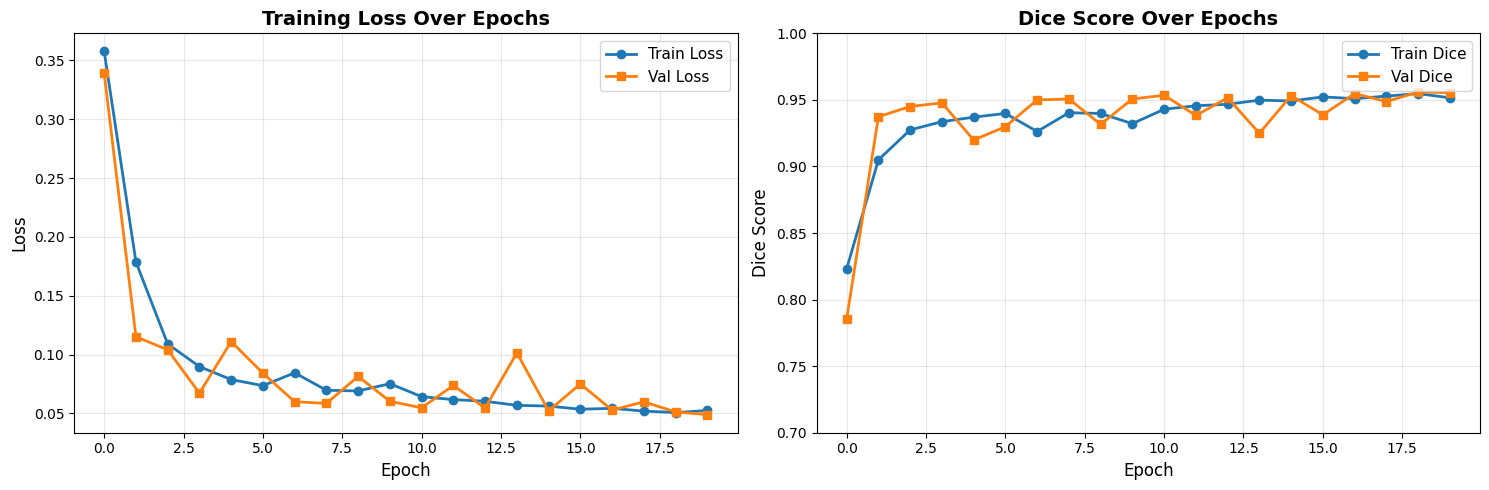

✓ Training curves saved!

TRAINING SUMMARY
Best Val Dice: 0.9559 (Epoch 19)
Best Val Loss: 0.0490
Final Train Dice: 0.9516
Final Val Dice: 0.9554


In [18]:
import matplotlib.pyplot as plt
import json
import os

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'

# Load training history
history_path = f'{PROJECT_ROOT}/results/training_history.json'
with open(history_path, 'r') as f:
    history = json.load(f)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2, marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2, marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot Dice score
axes[1].plot(history['train_dice'], label='Train Dice', linewidth=2, marker='o')
axes[1].plot(history['val_dice'], label='Val Dice', linewidth=2, marker='s')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Dice Score', fontsize=12)
axes[1].set_title('Dice Score Over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.7, 1.0])

plt.tight_layout()
plot_path = f'{PROJECT_ROOT}/results/plots/training_curves.png'
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved!")

# Print final metrics
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"Best Val Dice: {max(history['val_dice']):.4f} (Epoch {history['val_dice'].index(max(history['val_dice']))+1})")
print(f"Best Val Loss: {min(history['val_loss']):.4f}")
print(f"Final Train Dice: {history['train_dice'][-1]:.4f}")
print(f"Final Val Dice: {history['val_dice'][-1]:.4f}")
print("="*70)


✓ Model loaded!



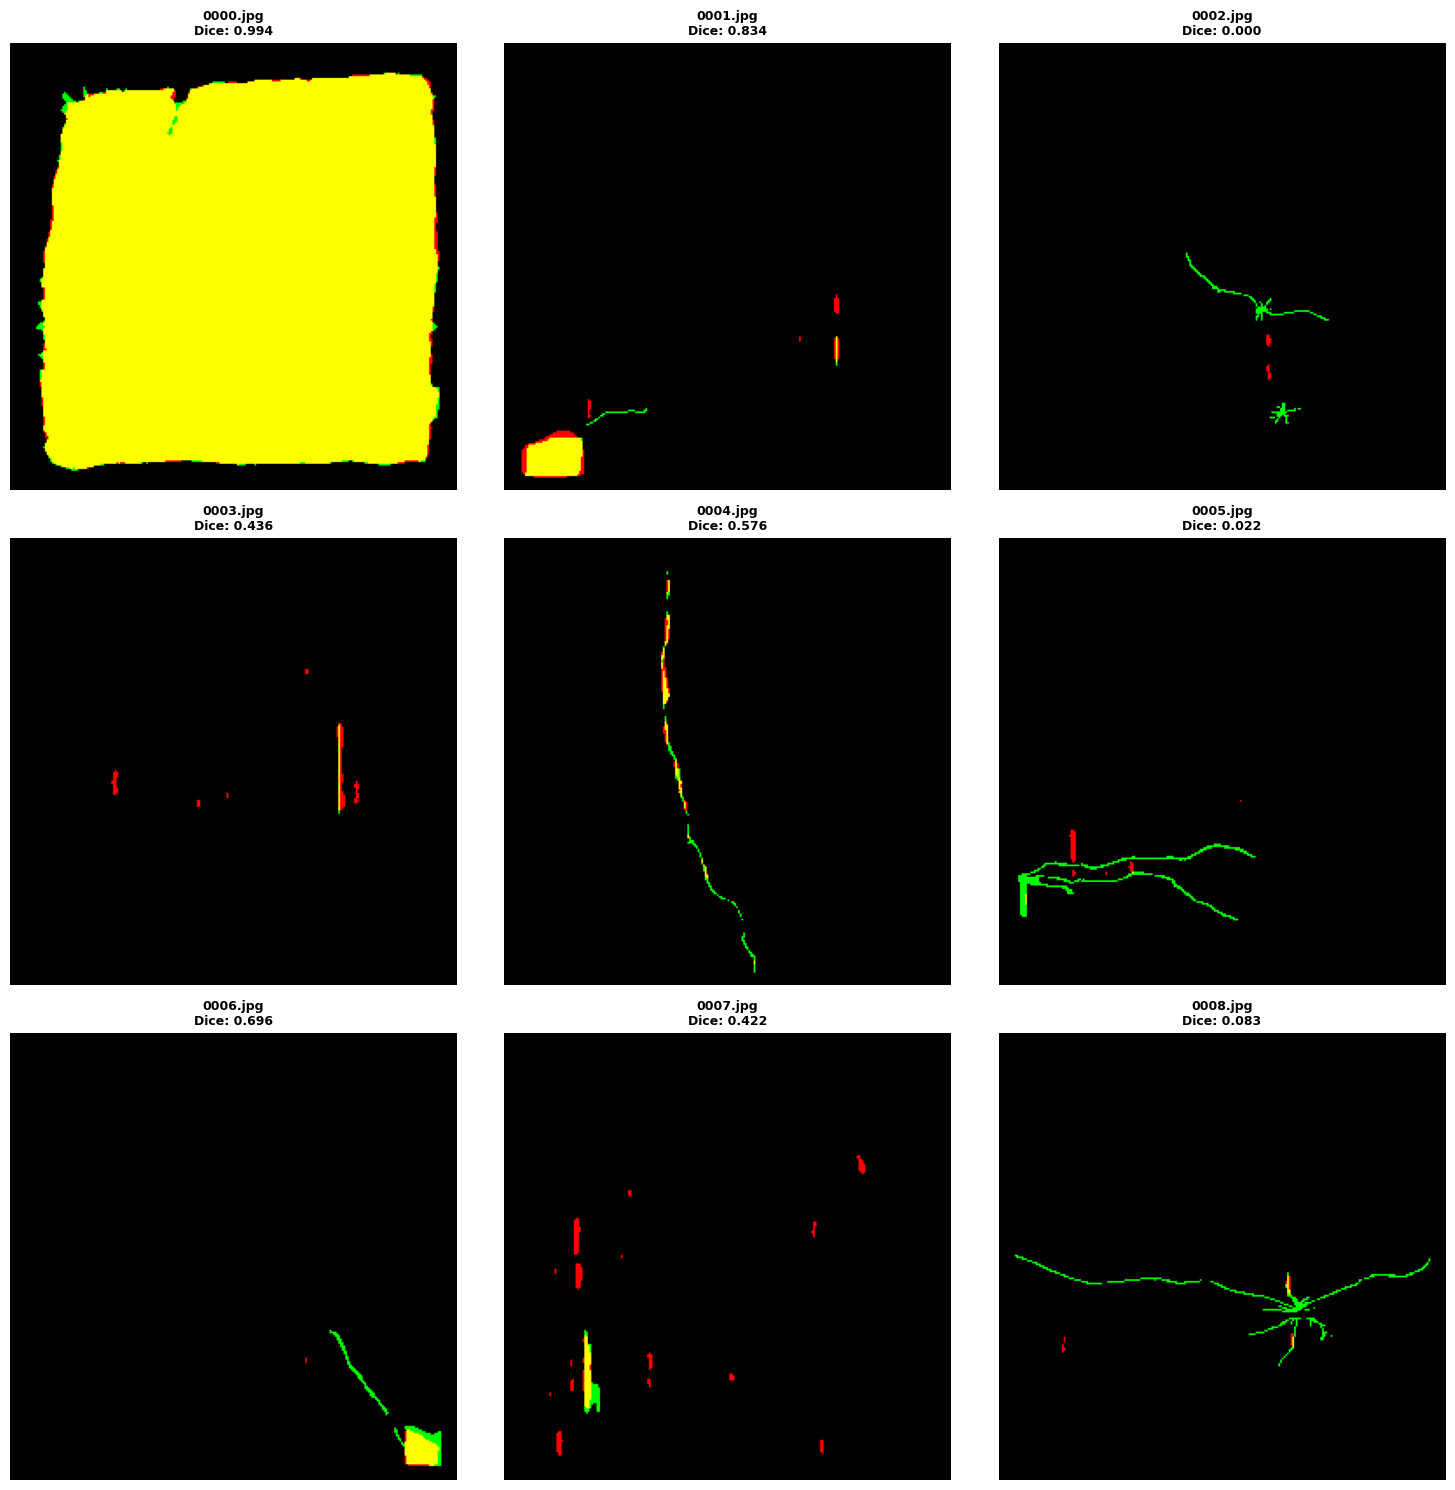

✓ Predictions visualized and saved!
   File: /content/drive/MyDrive/solar-defect-detection/results/plots/predictions_comparison.png

   Color Legend:
   🟢 Green = Ground Truth Defects
   🔴 Red   = Model Predictions
   ⚪ Purple (overlap) = Correct Detections


In [21]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load trained model
model = UNet(in_channels=1, out_channels=1).to(device)
model_path = f'{PROJECT_ROOT}/models/best_model.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

print("✓ Model loaded!\n")

# Get test images
test_image_dir = f'{PROJECT_ROOT}/data/processed/test/images'
test_mask_dir = f'{PROJECT_ROOT}/data/processed/test/masks'

# Get list of test images - Fixed: Use only 9 samples for 3x3 grid
test_images = sorted([f for f in os.listdir(test_image_dir) if f.endswith('.jpg')])[:9]

# Create predictions with 3x3 grid (9 samples total)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

with torch.no_grad():
    for idx, img_name in enumerate(test_images):
        # Load image
        img_path = os.path.join(test_image_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256, 256))

        # Load ground truth mask
        mask_name = img_name.replace('.jpg', '_mask.jpg')
        mask_path = os.path.join(test_mask_dir, mask_name)
        gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt_mask = cv2.resize(gt_mask, (256, 256))

        # Predict
        image_tensor = torch.from_numpy(image.astype(np.float32) / 255.0).unsqueeze(0).unsqueeze(0).to(device)
        prediction = model(image_tensor)
        pred_mask = prediction.squeeze().cpu().numpy()

        # Threshold prediction
        pred_mask_binary = (pred_mask > 0.5).astype(np.uint8) * 255

        # Blend prediction and ground truth for comparison
        # Green = correct, Red = false positive, Blue = false negative
        comparison = np.zeros((256, 256, 3), dtype=np.uint8)
        comparison[gt_mask > 128, 1] = 255      # Ground truth in green
        comparison[pred_mask_binary > 128, 0] = 255  # Prediction in red

        # Show comparison
        axes[idx].imshow(comparison)

        # Calculate Dice for this sample
        smooth = 1e-5
        pred_flat = pred_mask_binary.flatten().astype(np.float32) / 255.0
        gt_flat = gt_mask.flatten().astype(np.float32) / 255.0
        dice = (2.0 * np.sum(pred_flat * gt_flat) + smooth) / (np.sum(pred_flat) + np.sum(gt_flat) + smooth)

        axes[idx].set_title(f'{img_name}\nDice: {dice:.3f}', fontsize=9, fontweight='bold')
        axes[idx].axis('off')

plt.tight_layout()
pred_path = f'{PROJECT_ROOT}/results/plots/predictions_comparison.png'
os.makedirs(os.path.dirname(pred_path), exist_ok=True)
plt.savefig(pred_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Predictions visualized and saved!")
print(f"   File: {pred_path}")
print(f"\n   Color Legend:")
print(f"   🟢 Green = Ground Truth Defects")
print(f"   🔴 Red   = Model Predictions")
print(f"   ⚪ Purple (overlap) = Correct Detections")


In [20]:
# Calculate evaluation metrics on test set
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def calculate_metrics(predictions, ground_truth):
    """Calculate various segmentation metrics"""
    # Threshold predictions
    pred_binary = (predictions > 0.5).astype(np.uint8).flatten()
    gt_binary = (ground_truth > 0.5).astype(np.uint8).flatten()

    # Calculate metrics
    precision = precision_score(gt_binary, pred_binary, zero_division=0)
    recall = recall_score(gt_binary, pred_binary, zero_division=0)
    f1 = f1_score(gt_binary, pred_binary, zero_division=0)
    iou = np.sum(pred_binary & gt_binary) / np.sum(pred_binary | gt_binary)

    return precision, recall, f1, iou

# Evaluate on all test data
all_precisions = []
all_recalls = []
all_f1s = []
all_ious = []

test_image_dir = f'{PROJECT_ROOT}/data/processed/test/images'
test_mask_dir = f'{PROJECT_ROOT}/data/processed/test/masks'
test_images = sorted([f for f in os.listdir(test_image_dir) if f.endswith('.jpg')])

print("Evaluating on test set...")

with torch.no_grad():
    for img_name in test_images:
        # Load image
        img_path = os.path.join(test_image_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256, 256))

        # Load mask
        mask_name = img_name.replace('.jpg', '_mask.jpg')
        mask_path = os.path.join(test_mask_dir, mask_name)
        gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt_mask = cv2.resize(gt_mask, (256, 256))

        # Predict
        image_tensor = torch.from_numpy(image.astype(np.float32) / 255.0).unsqueeze(0).unsqueeze(0).to(device)
        prediction = model(image_tensor).squeeze().cpu().numpy()

        # Calculate metrics
        precision, recall, f1, iou = calculate_metrics(prediction, gt_mask)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)
        all_ious.append(iou)

# Average metrics
avg_precision = np.mean(all_precisions)
avg_recall = np.mean(all_recalls)
avg_f1 = np.mean(all_f1s)
avg_iou = np.mean(all_ious)

print("\n" + "="*70)
print("TEST SET EVALUATION METRICS")
print("="*70)
print(f"Precision: {avg_precision:.4f}")
print(f"Recall:    {avg_recall:.4f}")
print(f"F1 Score:  {avg_f1:.4f}")
print(f"IoU:       {avg_iou:.4f}")
print("="*70)

# Save metrics
metrics = {
    'precision': avg_precision,
    'recall': avg_recall,
    'f1_score': avg_f1,
    'iou': avg_iou,
    'best_dice': max(history['val_dice'])
}

metrics_path = f'{PROJECT_ROOT}/results/evaluation_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=4)

print(f"\n✓ Metrics saved to: {metrics_path}")


Evaluating on test set...

TEST SET EVALUATION METRICS
Precision: 0.6784
Recall:    0.4811
F1 Score:  0.5038
IoU:       0.4454

✓ Metrics saved to: /content/drive/MyDrive/solar-defect-detection/results/evaluation_metrics.json


In [22]:
# Detailed analysis of test samples
test_image_dir = f'{PROJECT_ROOT}/data/processed/test/images'
test_mask_dir = f'{PROJECT_ROOT}/data/processed/test/masks'
test_images = sorted([f for f in os.listdir(test_image_dir) if f.endswith('.jpg')])

sample_dice_scores = []

with torch.no_grad():
    for img_name in test_images[:30]:  # Check first 30 samples
        img_path = os.path.join(test_image_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256, 256))

        mask_name = img_name.replace('.jpg', '_mask.jpg')
        mask_path = os.path.join(test_mask_dir, mask_name)
        gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt_mask = cv2.resize(gt_mask, (256, 256))

        # Predict
        image_tensor = torch.from_numpy(image.astype(np.float32) / 255.0).unsqueeze(0).unsqueeze(0).to(device)
        prediction = model(image_tensor).squeeze().cpu().numpy()

        # Calculate Dice
        smooth = 1e-5
        pred = prediction.flatten()
        gt = (gt_mask.flatten().astype(np.float32) / 255.0)
        dice = (2.0 * np.sum(pred * gt) + smooth) / (np.sum(pred) + np.sum(gt) + smooth)

        sample_dice_scores.append((img_name, dice))

# Sort by Dice score
sample_dice_scores.sort(key=lambda x: x[1])

print("="*70)
print("SAMPLE-WISE PERFORMANCE")
print("="*70)
print("\nWORST 5 PREDICTIONS:")
for name, dice in sample_dice_scores[:5]:
    print(f"  {name}: {dice:.4f}")

print("\nBEST 5 PREDICTIONS:")
for name, dice in sample_dice_scores[-5:]:
    print(f"  {name}: {dice:.4f}")

print(f"\nAverage Dice on samples: {np.mean([d for _, d in sample_dice_scores]):.4f}")
print("="*70)


SAMPLE-WISE PERFORMANCE

WORST 5 PREDICTIONS:
  0017.jpg: 0.0283
  0024.jpg: 0.0379
  0011.jpg: 0.0390
  0022.jpg: 0.0583
  0021.jpg: 0.0970

BEST 5 PREDICTIONS:
  0019.jpg: 0.9727
  0016.jpg: 0.9815
  0028.jpg: 0.9913
  0018.jpg: 0.9914
  0000.jpg: 0.9927

Average Dice on samples: 0.3849


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import json
import os

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============================================
# WEIGHTED LOSS FUNCTION FOR CLASS IMBALANCE
# ============================================

class WeightedDiceLoss(nn.Module):
    """
    Weighted Dice Loss that handles class imbalance
    - Gives higher weight to hard negatives (sparse defects)
    """
    def __init__(self):
        super(WeightedDiceLoss, self).__init__()

    def forward(self, pred, target):
        smooth = 1e-5
        pred = pred.view(-1)
        target = target.view(-1)

        # Calculate defect ratio (percentage of defective pixels)
        defect_ratio = target.mean()

        # If defects are sparse (< 10%), weight them higher
        if defect_ratio < 0.1:
            defect_weight = 1.0 / (defect_ratio + smooth)
        else:
            defect_weight = 1.0

        # Weighted intersection
        intersection = (pred * target).sum()

        # Weighted Dice loss
        dice = (2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth)
        return (1 - dice) * defect_weight

class FocalLoss(nn.Module):
    """
    Focal Loss - focuses on hard examples
    Better for imbalanced datasets
    """
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        # Binary cross entropy
        bce = nn.BCELoss(reduction='none')(pred, target)

        # Focal term
        pt = torch.where(target == 1, pred, 1 - pred)
        focal_weight = (1 - pt) ** self.gamma

        # Focal loss
        focal = self.alpha * focal_weight * bce
        return focal.mean()

def train_epoch_v2(model, train_loader, optimizer, device):
    """Train for one epoch with weighted loss"""
    model.train()
    total_loss = 0
    total_dice = 0

    pbar = tqdm(train_loader, desc="Training", leave=False)
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        # Combine multiple losses
        bce_loss = nn.BCELoss()(outputs, masks)
        focal_loss = FocalLoss()(outputs, masks)
        dice_loss = WeightedDiceLoss()(outputs, masks)

        # Total loss
        loss = 0.3 * bce_loss + 0.3 * focal_loss + 0.4 * dice_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        total_dice += dice_score(outputs, masks)

        loss_val = loss.item()
        pbar.set_postfix({'loss': f'{loss_val:.4f}'})

    return total_loss / len(train_loader), total_dice / len(train_loader)

def validate_v2(model, test_loader, device):
    """Validate with weighted metrics"""
    model.eval()
    total_loss = 0
    total_dice = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validating", leave=False):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            bce_loss = nn.BCELoss()(outputs, masks)
            focal_loss = FocalLoss()(outputs, masks)
            dice_loss = WeightedDiceLoss()(outputs, masks)

            loss = 0.3 * bce_loss + 0.3 * focal_loss + 0.4 * dice_loss

            # Metrics
            total_loss += loss.item()
            total_dice += dice_score(outputs, masks)

    return total_loss / len(test_loader), total_dice / len(test_loader)

# Training parameters
num_epochs = 15  # Shorter training - weighted loss learns faster
learning_rate = 0.0005  # Lower learning rate for stability
batch_size = 16

# Initialize model
model = UNet(in_channels=1, out_channels=1).to(device)

# Use SGD with momentum instead of Adam (works better with focal loss)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training history
history_v2 = {
    'train_loss': [],
    'train_dice': [],
    'val_loss': [],
    'val_dice': []
}

print("="*70)
print("RETRAINING WITH WEIGHTED LOSS FOR CLASS IMBALANCE")
print("="*70)
print(f"Device: {device}")
print(f"Loss: 30% BCE + 30% Focal + 40% Weighted Dice")
print(f"Epochs: {num_epochs}")
print(f"Learning rate: {learning_rate}")
print("="*70 + "\n")

# Training loop
for epoch in range(num_epochs):
    train_loss, train_dice = train_epoch_v2(model, train_loader, optimizer, device)
    val_loss, val_dice = validate_v2(model, test_loader, device)

    # Store history
    history_v2['train_loss'].append(train_loss)
    history_v2['train_dice'].append(train_dice)
    history_v2['val_loss'].append(val_loss)
    history_v2['val_dice'].append(val_dice)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Dice:   {val_dice:.4f}")

    # Save best model
    if epoch == 0 or val_dice > max(history_v2['val_dice'][:-1]):
        model_path = f'{PROJECT_ROOT}/models/best_model_v2_weighted.pth'
        torch.save(model.state_dict(), model_path)
        print(f"  ✓ Best model saved!")
    print()

# Save training history
history_path = f'{PROJECT_ROOT}/results/training_history_v2_weighted.json'
with open(history_path, 'w') as f:
    json.dump(history_v2, f, indent=4)

print("="*70)
print("✅ RETRAINING COMPLETE WITH WEIGHTED LOSS!")
print("="*70)
print(f"Model saved: {PROJECT_ROOT}/models/best_model_v2_weighted.pth")


RETRAINING WITH WEIGHTED LOSS FOR CLASS IMBALANCE
Device: cuda
Loss: 30% BCE + 30% Focal + 40% Weighted Dice
Epochs: 15
Learning rate: 0.0005



Epoch 1/15
  Train Loss: 1.0946 | Train Dice: 0.5613
  Val Loss:   0.9495 | Val Dice:   0.6300
  ✓ Best model saved!



Epoch 2/15
  Train Loss: 1.1356 | Train Dice: 0.6141
  Val Loss:   0.8255 | Val Dice:   0.6687
  ✓ Best model saved!



Epoch 3/15
  Train Loss: 0.6437 | Train Dice: 0.6987
  Val Loss:   0.6772 | Val Dice:   0.8403
  ✓ Best model saved!



Epoch 4/15
  Train Loss: 0.7729 | Train Dice: 0.8153
  Val Loss:   0.4916 | Val Dice:   0.8874
  ✓ Best model saved!



Epoch 5/15
  Train Loss: 0.3607 | Train Dice: 0.8666
  Val Loss:   0.3960 | Val Dice:   0.9089
  ✓ Best model saved!



Epoch 6/15
  Train Loss: 0.5410 | Train Dice: 0.8669
  Val Loss:   0.6837 | Val Dice:   0.4698



Epoch 7/15
  Train Loss: 0.2227 | Train Dice: 0.9017
  Val Loss:   0.2506 | Val Dice:   0.9359
  ✓ Best model saved!



Epoch 8/15
  Train Loss: 0.3777 | Train Dice: 0.9016
  Val Loss:   0.2244 | Val Dice:   0.9316



Epoch 9/15
  Train Loss: 1.3308 | Train Dice: 0.6066
  Val Loss:   0.2841 | Val Dice:   0.8780



Epoch 10/15
  Train Loss: 0.3434 | Train Dice: 0.8737
  Val Loss:   0.5315 | Val Dice:   0.5895



Epoch 11/15
  Train Loss: 0.1775 | Train Dice: 0.9121
  Val Loss:   0.1908 | Val Dice:   0.9238



Epoch 12/15
  Train Loss: 0.1846 | Train Dice: 0.9207
  Val Loss:   0.1701 | Val Dice:   0.9380
  ✓ Best model saved!



Epoch 13/15
  Train Loss: 0.1258 | Train Dice: 0.9277
  Val Loss:   0.1481 | Val Dice:   0.9438
  ✓ Best model saved!



Epoch 14/15
  Train Loss: 0.2150 | Train Dice: 0.9155
  Val Loss:   0.1527 | Val Dice:   0.9419



Epoch 15/15
  Train Loss: 0.2228 | Train Dice: 0.9253
  Val Loss:   0.1305 | Val Dice:   0.9498
  ✓ Best model saved!

✅ RETRAINING COMPLETE WITH WEIGHTED LOSS!
Model saved: /content/drive/MyDrive/solar-defect-detection/models/best_model_v2_weighted.pth


In [24]:
# Load new weighted model
model_v2 = UNet(in_channels=1, out_channels=1).to(device)
model_v2.load_state_dict(torch.load(f'{PROJECT_ROOT}/models/best_model_v2_weighted.pth'))
model_v2.eval()

# Evaluate on test set
all_precisions = []
all_recalls = []
all_f1s = []
all_ious = []

test_image_dir = f'{PROJECT_ROOT}/data/processed/test/images'
test_mask_dir = f'{PROJECT_ROOT}/data/processed/test/masks'
test_images = sorted([f for f in os.listdir(test_image_dir) if f.endswith('.jpg')])

print("Evaluating V2 model on test set...\n")

with torch.no_grad():
    for img_name in test_images:
        img_path = os.path.join(test_image_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256, 256))

        mask_name = img_name.replace('.jpg', '_mask.jpg')
        mask_path = os.path.join(test_mask_dir, mask_name)
        gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt_mask = cv2.resize(gt_mask, (256, 256))

        image_tensor = torch.from_numpy(image.astype(np.float32) / 255.0).unsqueeze(0).unsqueeze(0).to(device)
        prediction = model_v2(image_tensor).squeeze().cpu().numpy()

        precision, recall, f1, iou = calculate_metrics(prediction, gt_mask)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)
        all_ious.append(iou)

# Average metrics
avg_precision_v2 = np.mean(all_precisions)
avg_recall_v2 = np.mean(all_recalls)
avg_f1_v2 = np.mean(all_f1s)
avg_iou_v2 = np.mean(all_ious)

print("="*70)
print("COMPARISON: V1 vs V2")
print("="*70)
print(f"{'Metric':<15} {'V1 (Original)':<20} {'V2 (Weighted)':<20}")
print("-"*70)
print(f"{'Precision':<15} {0.6784:<20.4f} {avg_precision_v2:<20.4f}")
print(f"{'Recall':<15} {0.4811:<20.4f} {avg_recall_v2:<20.4f}")
print(f"{'F1 Score':<15} {0.5038:<20.4f} {avg_f1_v2:<20.4f}")
print(f"{'IoU':<15} {0.4454:<20.4f} {avg_iou_v2:<20.4f}")
print("="*70)

if avg_f1_v2 > 0.5038:
    improvement = ((avg_f1_v2 - 0.5038) / 0.5038) * 100
    print(f"✅ IMPROVEMENT: +{improvement:.1f}% better F1 Score!")
else:
    print("⚠️ No improvement yet - might need more tuning")


Evaluating V2 model on test set...

COMPARISON: V1 vs V2
Metric          V1 (Original)        V2 (Weighted)       
----------------------------------------------------------------------
Precision       0.6784               0.4476              
Recall          0.4811               0.4017              
F1 Score        0.5038               0.4120              
IoU             0.4454               0.3828              
⚠️ No improvement yet - might need more tuning


In [25]:
from google.colab import files
import os

PROJECT_ROOT = '/content/drive/MyDrive/solar-defect-detection'

# Download model
print("Downloading best model...")
files.download(f'{PROJECT_ROOT}/models/best_model.pth')

# Download training history
print("Downloading training history...")
files.download(f'{PROJECT_ROOT}/results/training_history.json')

# Download metrics
print("Downloading evaluation metrics...")
files.download(f'{PROJECT_ROOT}/results/evaluation_metrics.json')

# Download visualizations
print("Downloading training curves...")
files.download(f'{PROJECT_ROOT}/results/plots/training_curves.png')

print("Downloading predictions...")
files.download(f'{PROJECT_ROOT}/results/plots/predictions_comparison.png')

print("\n✅ All files downloaded!")
print(f"\nYour model is saved in Google Drive: {PROJECT_ROOT}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All files downloaded!

Your model is saved in Google Drive: /content/drive/MyDrive/solar-defect-detection
